# Exploring Data from multiple sources

In [55]:
!pip install rasterio geopandas pandas numpy xarray

  Using cached pyproj-3.7.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (31 kB)
  Using cached shapely-2.1.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 11.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 11.2 MB/s eta 0:00:00a 0:00:01
Using cached pyproj-3.7.1-cp312-cp312-macosx_14_0_arm64.whl (4.7 MB)
Using cached shapely-2.1.0-cp312-cp312-macosx_11_0_arm64.whl (1.6 MB)


In [2]:
import csv
import pandas as pd
import os
import xarray as xr
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import rasterio
from datetime import datetime

### San Bernardino County, CA data points on drought
combined two datasets --> one with observed, monitored drought data and one with replicated, "predicted" drought data. Because the monitored drought data only starts from 2000, we decided to take the "historical" drought data from 1950 to 1999 and concatenate it with the observed dataset.

In [5]:
path = os.getcwd()

new_drought_df = pd.read_csv(path + '/data/SB_DroughtConditions.csv')
# print(new_drought_df.head())

# subset data so that it only includes dates from 2000 - 2024
# print(new_drought_df.dtypes)
new_drought_df = new_drought_df[new_drought_df['MapDate'] >= 20000101]
new_drought_df = new_drought_df[new_drought_df['MapDate'] <= 20241231]
# print(new_drought_df.head())

historical_drought_df = pd.read_csv(path + '/data/SB_historical_drought.csv')
# print(historical_drought_df.head())

# extract needed columns about drought
historical_drought_df = historical_drought_df[['DATE', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(historical_drought_df.dtypes)
# splice date string to only include yyyymmdd
historical_drought_df['DATE'] = historical_drought_df['DATE'].str[2:]
# subset data so that it only includes dates from 1950 - 1999
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] >= "19500101"]
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] <= "19991231"]
historical_drought_df.reset_index(drop=True)
# print(historical_drought_df.head())

# combine datasets
new_drought_df.rename(columns={'MapDate': 'DATE'}, inplace=True)
new_drought_df = new_drought_df[['DATE', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(new_drought_df.head())

# merge datasets
drought_df = pd.concat([historical_drought_df, new_drought_df], axis=0)
print(drought_df.head())

drought_df.to_csv("SB_drought_labels.csv", index=False)

         DATE    D0    D1    D2    D3    D4
660  19500101  90.1  83.9  57.9  40.8  16.1
661  19500201  92.7  89.4  72.4  50.8  13.1
662  19500301  95.8  90.4  68.8  48.5   8.3
663  19500401  96.1  90.9  70.6  43.6   0.2
664  19500501  97.5  90.8  76.8  29.2   0.1


### PRISM data preprocessing

In [ ]:
from rasterio.windows import Window

def load_prism_data(base_path):
    """Load PRISM data with robust error handling"""
    data = []
    dates = []
    
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            try:
                # Skip non-date folders
                date = datetime.strptime(dir_name, '%Y%m%d')
                dir_path = os.path.join(root, dir_name)
                
                # Look for .bil files (common PRISM format)
                for file in os.listdir(dir_path):
                    if file.endswith(".bil"):
                        file_path = os.path.join(dir_path, file)
                        try:
                            with rasterio.open(file_path) as src:
                                # Read first 1000x1000 pixels to verify data
                                array = src.read(1, window=Window(0, 0, 1000, 1000))
                                if np.all(array == src.nodata):
                                    print(f"No valid data in {file}")
                                    continue
                                data.append(np.nanmean(array))
                                dates.append(date.strftime('%Y-%m-%d'))
                        except rasterio.errors.RasterioIOError as e:
                            print(f"Error reading {file}: {str(e)}")
                            
            except ValueError:
                continue
                
    return pd.DataFrame({'Date': dates, 'PRISM_Value': data})

In [ ]:
# Main execution
prism_folder = path + "/data/prism_unzipped"
water_drought_path = path + "/data/water_drought.csv"

print(water_drought_path)
water_drought = pd.read_csv(water_drought_path)

# Load and merge data
prism_df = load_prism_data(prism_folder)
print(prism_df)

# Convert 'Date' in water_drought to datetime
water_drought['Date'] = pd.to_datetime(water_drought['Date'], errors='coerce')

# Convert 'Date' in prism_df to datetime (if not already done)
prism_df['Date'] = pd.to_datetime(prism_df['Date'], errors='coerce')

print("Water Drought Date dtype:", water_drought['Date'].dtype)
print("PRISM Date dtype:", prism_df['Date'].dtype)

final_df = pd.merge(
    water_drought.dropna(subset=['Date']),  # Remove invalid dates
    prism_df.dropna(subset=['Date']), 
    on='Date', 
    how='inner'  # Use 'inner' to ensure overlapping dates
)

print("Merged Data Sample:\n", final_df.head())

/Users/aimeeoh/Desktop/Documents/ColumbiaMS/MLC/ML-Climate/water_drought.csv
            Date  PRISM_Value
0     2019-07-09 -3388.621094
1     2023-06-18 -3389.373047
2     2021-08-11 -3390.122070
3     2022-02-28 -3390.125000
4     2022-08-26 -3389.744141
...          ...          ...
1821  2023-08-09 -3389.605469
1822  2019-03-16 -3390.907471
1823  2019-09-18 -3389.377441
1824  2019-01-24 -3388.126709
1825  2020-11-24 -3390.504150

[1826 rows x 2 columns]
Water Drought Date dtype: datetime64[ns]
PRISM Date dtype: datetime64[ns]
Merged Data Sample:
         Date      D0     D1     D2   D3   D4  Drought_Index  \
0 2019-01-01  100.00  99.84  10.88  0.0  0.0         45.392   
1 2019-01-08  100.00  99.84  10.88  0.0  0.0         45.392   
2 2019-01-15  100.00  99.84   9.97  0.0  0.0         44.937   
3 2019-01-22  100.00  82.69   0.00  0.0  0.0         34.807   
4 2019-01-29   99.85   8.20   0.00  0.0  0.0         12.445   

   RC1a_Temperature_Change  RC1c_Wildfire_Projections  RC2b_Wild

In [134]:
# Convert dates and sort
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.sort_values('Date', inplace=True)

# Select features and target
features = final_df.drop(columns=['Date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_df[['D0', 'D1', 'D2', 'D3', 'D4']]  # Multi-output regression

In [135]:
# Ensure proper data preparation
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Check if required columns exist
required_cols = ['Date', 'D0', 'D1', 'D2', 'D3', 'D4']
missing_cols = [col for col in required_cols if col not in final_df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in final_df: {missing_cols}")

# Add temporal features
final_df['day_of_year'] = final_df['Date'].dt.dayofyear
final_df['month'] = final_df['Date'].dt.month

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features = final_df.drop(columns=['Date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_df[['D0', 'D1', 'D2', 'D3', 'D4']]

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

print(f"Features shape: {X_scaled.shape}, Target shape: {y_scaled.shape}")

Features shape: (261, 10), Target shape: (261, 5)


In [136]:
# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])  # Predict next step after sequence
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 12  # Lookback period (12 weeks)
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

print(f"Sequence shapes - X_seq: {X_seq.shape}, y_seq: {y_seq.shape}")

Sequence shapes - X_seq: (249, 12, 10), y_seq: (249, 5)


In [137]:
# Split sequences into train and test sets
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(f"Train shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

Train shapes - X_train: (199, 12, 10), y_train: (199, 5)
Test shapes - X_test: (50, 12, 10), y_test: (50, 5)


In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)  # Output size matches the number of drought categories (D0-D4)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3861 - mae: 0.4590 - val_loss: 0.1024 - val_mae: 0.2475
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1850 - mae: 0.3526 - val_loss: 0.1493 - val_mae: 0.3517
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1117 - mae: 0.2839 - val_loss: 0.1388 - val_mae: 0.3355
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0787 - mae: 0.2250 - val_loss: 0.0780 - val_mae: 0.2324
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0592 - mae: 0.1849 - val_loss: 0.0666 - val_mae: 0.2139
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0595 - mae: 0.1886 - val_loss: 0.0660 - val_mae: 0.2126
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0459 - mae: 0.1630 - val_loss: 0.0692 - val_mae: 0.2175
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0495 - mae: 0.1630 - val_loss: 0.0744 - val_mae: 0.2249
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0460 - mae: 0.1550 - val_los

In [139]:
# Make predictions on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

print(f"Prediction shape: {y_pred.shape}, True labels shape: {y_test_orig.shape}")

# Evaluate using MAE for each drought category (D0-D4)
from sklearn.metrics import mean_absolute_error

for i, category in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred[:, i])
    print(f"MAE for {category}: {mae:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Prediction shape: (50, 5), True labels shape: (50, 5)
MAE for D0: 29.9055
MAE for D1: 17.4914
MAE for D2: 24.7793
MAE for D3: 13.5841
MAE for D4: 1.2776


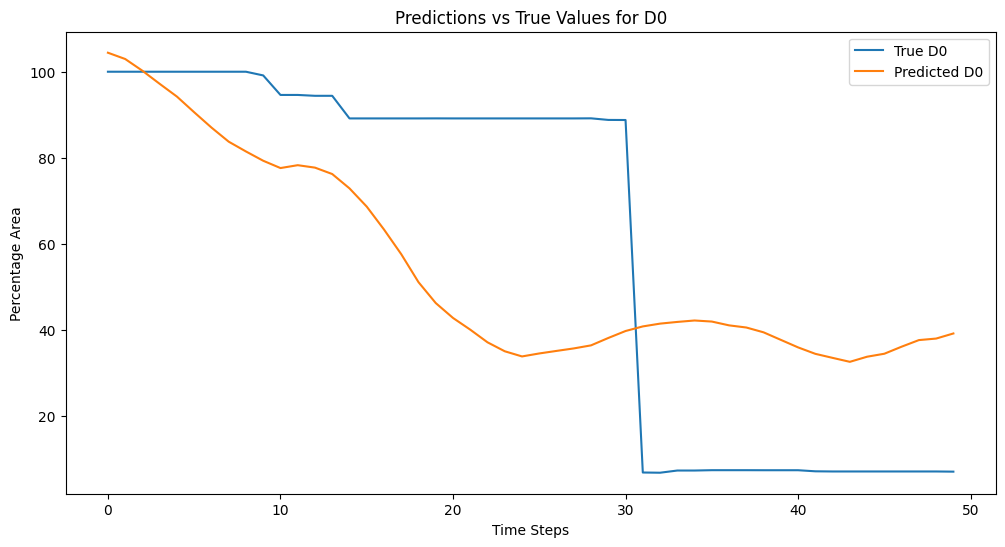

In [140]:
import matplotlib.pyplot as plt

# Plot predictions vs true values for D0 category as an example
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig[:, 0], label='True D0')
plt.plot(y_pred[:, 0], label='Predicted D0')
plt.title('Predictions vs True Values for D0')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Area')
plt.legend()
plt.show()


In [141]:
from sklearn.ensemble import RandomForestRegressor

# Flatten sequences for Random Forest (reshape to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_flat, y_train)

# Predict and evaluate RF model
rf_pred = rf_model.predict(X_test_flat)
rf_mae = mean_absolute_error(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae:.4f}")


Random Forest MAE: 0.1039


Accuracy: 0.9000
Confusion Matrix:
 [[45  5]
 [ 0  0]]


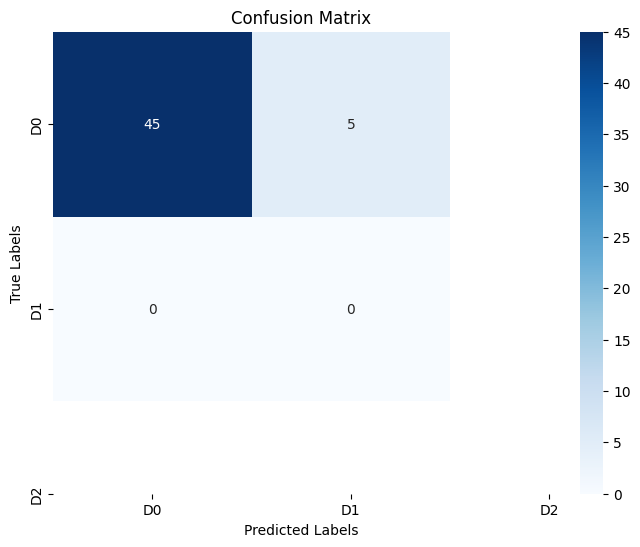

In [142]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Convert predictions and true values to categorical labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['D0', 'D1', 'D2'], yticklabels=['D0', 'D1', 'D2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Accuracy is variable. Goes form 0.74 to 0.9. Should do multiple runs of model? And should make model more robust. Maybe more data.

this is more classification --> change to prediction. Given this time period, predict the next week?

take weather, precipitation, and  --> datasets that give data on future date's climate

Do this after getting data --> causality with DoWhy --> codes up DAG

find the years that may have bad droughts/worst drought conditions

dew point (single value) if we're measuring one day (random day i.e. Jan 1st, 2066)
dew point if we have the previous week --> predict the next week (base off of trend/variability of temp, precip, dew point, humidity)

groundwater data for san bernardino

extract ppt, dp, etc. from tif file (maybe didn't do in the first run? -- find out)

Groundwater data -- combine dates from different well sites to get aggregate groundwater data per unique day.

In [5]:
# Load CSV data
df = pd.read_csv("SB_groundwater.csv", parse_dates=['datetime'])

# 1. Clean data: Ensure numeric values and filter provisional data (optional)
df['parameter_value'] = pd.to_numeric(df['parameter_value'], errors='coerce')
# df = df[df['qualification_cd'] == 'A']  # Uncomment to use only approved data

# 2. Group by date and sum parameter values
daily_totals = df.groupby('datetime', as_index=False).agg({
    'parameter_value': 'sum',
    'agency_cd': 'first'  # Assumes all rows are USGS
})

# 3. Rename columns and handle missing data
daily_totals = daily_totals.rename(columns={
    'parameter_value': 'total_parameter_value'
}).fillna(0)

# 4. Save consolidated data
daily_totals.to_csv("daily_groundwater_totals.csv", index=False)

print(daily_totals.head())

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_57915/1205911318.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("SB_groundwater.csv", parse_dates=['datetime'])


    datetime  total_parameter_value agency_cd
0 2000-01-01              638157.71      USGS
1 2000-01-02              637681.42      USGS
2 2000-01-03              634953.66      USGS
3 2000-01-04              634403.38      USGS
4 2000-01-05              637111.66      USGS


label droughts by type (flash drought for times when we go from D0 to Dk in a short period of time)